#Summary

This program uses a variety of models to generate original recipe text. A previous version of this code, under the same name, has been archived (in David's Google Drive).

The code is organized as follows. The first section loads in the data and sets it up as a TensorFlow Dataset. The second section defines and trains the models (each model is given a subsection). The third section covers recipe generation, and the fourth and final section is for experimental purposes. In that section, we are trying to develop a Generative Adversarial Network (GAN) for recipe generation.

# Code Sources
While most of the code in this file is our own, some of it was derived from the code written in [this blog post](https://www.kdnuggets.com/2020/07/generating-cooking-recipes-using-tensorflow.html), from author [Oleksii Trekhleb](https://github.com/trekhleb). Some of the overall structure of our program also follows the plan laid down in that post. Cells which use his code are clearly marked with a comment reading
``` # Oleksii Trekhleb ```
at the top.



# Section 1: Data Preparation

We connect the program to Google Drive, where the data and models are to be stored. Then we extract the data and prepare it for modeling, finishing by converting it into a TensorFlow Dataset.

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import packages

# general
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# data preparation
import sqlite3 # connect to database .db files
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# modeling
import pathlib # for setting up checkpoint directory
import os # ditto

In [ ]:
def import_data(n):
  ''' imports the first n recipes from the recipe database. '''
  
  with sqlite3.connect("/content/drive/Shareddrives/Gouda Group Project/recipes1M.db") as conn:
    query = \
    f"""
    SELECT R.title, R.ingredients, R.instructions
    FROM recipes R
    LIMIT ?
    """

    df = pd.read_sql_query(query, conn, params = [n])
  
  return df

In [ ]:
DATA_SIZE = 100000
data_raw = import_data(DATA_SIZE)

In [ ]:
# Oleksii Trekhleb

# define relevant constant values
STOP_WORD_TITLE = '📗 '
STOP_WORD_INGREDIENTS = '\n🥕\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝\n\n'

In [ ]:
def condense(title, ingr, instr):
  ''' 
  Each recipe is stored across three columns in the original data. This
  function condenses them into a single string, with marked boundaries.

  The concatenation steps in the end of this function were adapted from the code
  source discussed.
  '''

  # set up the ingredients
  temp1 = ingr # get string
  temp1 = temp1[1:-1] # remove outer quotations
  temp1 = temp1.split("\", ") # split into a list according to ",  sequence of those three characters
  temp1 = [item[1:] for item in temp1] # remove leading quotation
  temp1[len(temp1) - 1] = temp1[len(temp1) - 1][:-1] # remove ending quotation on last piece

  # set up the instructions
  temp2 = instr
  temp2 = temp2[1:-1]
  temp2 = temp2.split("\", ")
  temp2 = [item[1:] for item in temp2]
  temp2[len(temp2) - 1] = temp2[len(temp2) - 1][:-1]
    
  ingr_string = ''
  for ingredient in temp1:
    ingr_string += f'• {ingredient}\n'

  instr_string = ''
  for instruction in temp2:
    instr_string += f'• {instruction}\n'

  return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingr_string}{STOP_WORD_INSTRUCTIONS}{instr_string}'

In [ ]:
# condense each recipe into a single string
data_str = data_raw.apply(lambda x: condense(x.title, x.ingredients, x.instructions), axis = 1)

In [ ]:
# Oleksii Trekhleb
MAX_RECIPE_LENGTH = 2000

def filter(recipe):
  ''' removes recipes that are too long. '''
  return len(recipe) <= MAX_RECIPE_LENGTH 

data_filter = [recipe for recipe in data_str if filter(recipe)] 

In [ ]:
# Oleksii Trekhleb (adapted)

STOP_SIGN = '␣' # will be appended to the end of each recipe

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters = '', # we do not want to filter our recipes
    lower = False, # we want the model to recognize uppercase characters
    split = '', # we are using characters, not words
    char_level = True # we want a character-level RNN
)

# show the tokenizer all of the existing characters we have
tokenizer.fit_on_texts([STOP_SIGN])
tokenizer.fit_on_texts(data_filter)

tokenizer.get_config() # show results

{'char_level': True,
 'document_count': 94136,
 'filters': '',
 'index_docs': '{"1": 94135, "101": 1, "34": 70465, "38": 65029, "6": 94130, "2": 94135, "25": 89419, "35": 59588, "19": 93812, "4": 94133, "7": 94131, "31": 78336, "14": 94029, "9": 94130, "3": 94126, "55": 26345, "49": 94135, "10": 94111, "16": 94034, "33": 74283, "32": 76497, "39": 64915, "51": 51101, "47": 94135, "23": 93354, "15": 94095, "24": 92673, "42": 64041, "26": 91327, "27": 90429, "8": 94123, "29": 90369, "28": 90400, "12": 94135, "18": 93792, "62": 32509, "11": 94079, "20": 93543, "22": 92324, "54": 39644, "17": 94135, "44": 54366, "41": 62330, "30": 82207, "46": 52304, "48": 94135, "13": 94120, "5": 94116, "21": 93421, "36": 66005, "59": 31291, "70": 12369, "64": 21373, "45": 41533, "58": 36437, "61": 32407, "52": 47844, "37": 70695, "63": 30461, "53": 43677, "43": 61155, "73": 9668, "60": 26479, "40": 59826, "75": 10409, "65": 18289, "56": 36455, "76": 8657, "50": 48091, "84": 1147, "69": 15236, "66": 14933,

In [ ]:
# Oleksii Trekhleb
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1 # record for later
print(VOCABULARY_SIZE)

data_vec = tokenizer.texts_to_sequences(data_filter) # vectorize the data

102


In [ ]:
# Oleksii Trekhleb (adapted)

# standardize recipe length to 2001. We will split off one character later.
data_temp = tf.keras.preprocessing.sequence.pad_sequences(
    sequences = data_vec,
    maxlen = MAX_RECIPE_LENGTH - 1, # create room for stop signs at the end
    padding = "post",
    truncating = "post",
    value = tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

data_pad = tf.keras.preprocessing.sequence.pad_sequences(
    sequences = data_temp,
    maxlen = MAX_RECIPE_LENGTH + 1, # add on the stop signs
    padding = "post",
    truncating = "post",
    value = tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset = tf.data.Dataset.from_tensor_slices(data_pad)

In [ ]:
# Oleksii Trekhleb

def split_input_target(recipe):
  ''' separate each string by removing one of the end characters, for model prediction later. '''
  input_text = recipe[:-1]
  target_text = recipe[1:]
    
  return input_text, target_text

data_target = dataset.map(split_input_target)

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

# batches the data to save memory later
# shuffles and repeats in order to allow for infinite training (on the data end)
data_train = data_target.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True).repeat()

# Section 2: Modeling

In this section, we define and train a variety of models, each of which is given its own subsection. Each model (re)defines various constants as needed, and sets up a directory to save its progress.

## Model 1: Baseline

This is an LSTM model that was implemented by Oleksii Trekhleb. We have made slight modifications.

In [ ]:
# Oleksii Trekhleb (adapted)

# set up directory and checkpoint saving

dir = "/content/drive/Shareddrives/Gouda Group Project/recipe_model/baseline"
checkpoint = os.path.join(dir, "checkpoint_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint,
    save_weights_only = True
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           26112     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 102)           104550    
Total params: 5,377,638
Trainable params: 5,377,638
Non-trainable params: 0
_________________________________________________________________


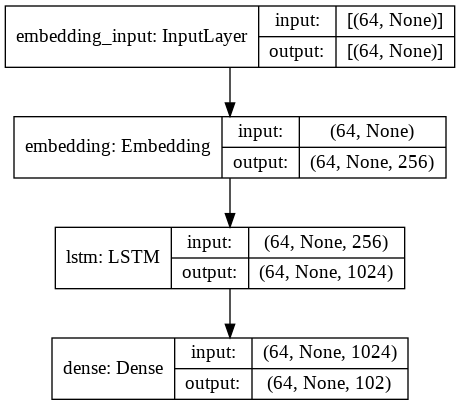

In [ ]:
# Oleksii Trekhleb (adapted)

# define model

# constants
EMBEDDING_SIZE = 256
UNITS = 1024

model = tf.keras.models.Sequential([
  layers.Embedding(input_dim = VOCABULARY_SIZE,
                   output_dim = EMBEDDING_SIZE,
                   batch_input_shape = [BATCH_SIZE, None]),
  layers.LSTM(units = UNITS,
              return_sequences = True,
              stateful = True,
              recurrent_initializer = tf.keras.initializers.GlorotNormal()),
  layers.Dense(VOCABULARY_SIZE)         
])

# show description
model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_layer_names = True
)

In [ ]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True))

In [ ]:
# Oleksii Trekhleb (constant values modified)

# constants
EPOCHS = 5 # how long to train
INITIAL_EPOCH = 1 # resume from this epoch
STEPS_PER_EPOCH = 1000

history = model.fit(
    x = data_train,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    initial_epoch = INITIAL_EPOCH,
    callbacks = [checkpoint_callback],
    verbose = True
)

Epoch 2/5
1000/1000 [==============================] - 1282s 1s/step - loss: 1.0458
Epoch 3/5
1000/1000 [==============================] - 1293s 1s/step - loss: 0.5845
Epoch 4/5
1000/1000 [==============================] - 1291s 1s/step - loss: 0.4465
Epoch 5/5
1000/1000 [==============================] - 1289s 1s/step - loss: 0.3890


## Model 2: GRU

After seeing the output of the baseline model, I was rather unimpressed. In reading about RNNs online, it looks like Gated Recurrent Units (GRUs) can learn more quickly than LSTMs. So in this model, we will use a GRU layer instead. We also increase the embedding dimension so that there are still roughly the same number of parameters

In [ ]:
# set up directory and checkpoint saving

dir = "/content/drive/Shareddrives/Gouda Group Project/recipe_model/gru1"
checkpoint = os.path.join(dir, "checkpoint_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint,
    save_weights_only = True
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (64, None, 512)           52224     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          4724736   
_________________________________________________________________
dense_5 (Dense)              (64, None, 102)           104550    
Total params: 4,881,510
Trainable params: 4,881,510
Non-trainable params: 0
_________________________________________________________________


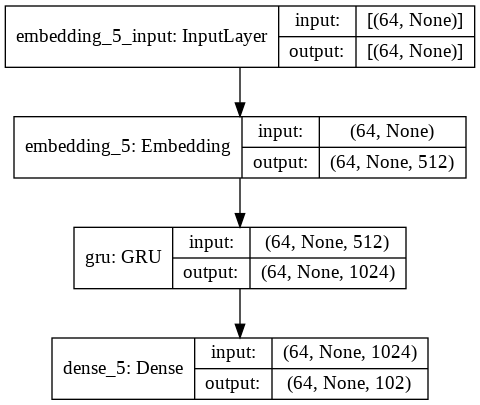

In [ ]:
# constants
EMBEDDING_SIZE = 512
UNITS = 1024

model = tf.keras.models.Sequential([
  layers.Embedding(input_dim = VOCABULARY_SIZE,
                   output_dim = EMBEDDING_SIZE,
                   batch_input_shape = [BATCH_SIZE, None]),
  layers.GRU(units = UNITS,
             return_sequences = True,
             stateful = True),
  layers.Dense(VOCABULARY_SIZE)         
])

# show description
model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    show_layer_names = True
)

In [ ]:
model.compile(optimizer = "adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True))

In [ ]:
# constants
EPOCHS = 5 # how long to train
INITIAL_EPOCH = 1 # resume from this epoch
STEPS_PER_EPOCH = 1000

history = model.fit(
    x = data_train,
    epochs = EPOCHS,
    steps_per_epoch = STEPS_PER_EPOCH,
    initial_epoch = INITIAL_EPOCH,
    callbacks = [checkpoint_callback],
    verbose = True
)

Epoch 2/5
1000/1000 [==============================] - 1236s 1s/step - loss: 1.1965
Epoch 3/5
1000/1000 [==============================] - 1239s 1s/step - loss: 0.3937
Epoch 4/5
1000/1000 [==============================] - 1237s 1s/step - loss: 0.3409
Epoch 5/5
1000/1000 [==============================] - 1238s 1s/step - loss: 0.3203


# Section 3: Generating

We use the models trained in Section 2 to generate new recipes.

In [ ]:
# Oleksii Treklheb

# set up model with batch size 1, to facilitate faster generation

EMBEDDING_SIZE = 256
UNITS = 1024

generator = tf.keras.models.Sequential([
  layers.Embedding(input_dim = VOCABULARY_SIZE,
                   output_dim = EMBEDDING_SIZE,
                   batch_input_shape = [1, None]),
  layers.LSTM(units = UNITS,
              return_sequences = True,
              stateful = True,
              recurrent_initializer = tf.keras.initializers.GlorotNormal()),
  layers.Dense(VOCABULARY_SIZE)         
])

# load weights
generator.load_weights("/content/drive/Shareddrives/Gouda Group Project/recipe_model/baseline/checkpoint_4")
generator.build(tf.TensorShape([1, None]))

In [ ]:
# Oleksii Trekhleb (adapted)

def generate(model, seed, length, temperature):
  ''' generates text of length length, using the provided seed text and model. '''
  start = STOP_WORD_TITLE + seed
  indices = np.array(tokenizer.texts_to_sequences([start])) # vectorize
  result = []

  model.reset_states() # make separate predictions independent
  for char in range(length): # predict next character
    preds = model(indices)
    preds = tf.squeeze(preds, 0) # reduce a dimension
    preds = preds / temperature

    # pick next character
    pred_id = tf.random.categorical(preds, num_samples = 1)[-1, 0].numpy()
    
    # add the predicted character
    indices = tf.expand_dims([pred_id], 0)
    next_char = tokenizer.sequences_to_texts(indices.numpy())[0]
    result.append(next_char)

  return (start + ''.join(result))

In [ ]:
seeds = ["pasta", "salmon"]
temps = [0.1, 0.2, 0.5, 0.8]

recipes = []
for seed in seeds:
  for temp in temps:
    recipes.append(generate(generator, seed, 500, temp))
    print("----- RECIPE -----")
    print("SEED: ", seed, ", TEMPERATURE: ", temp)
    print(recipes[len(recipes) - 1])

----- RECIPE -----
SEED:  pasta , TEMPERATURE:  0.1
📗 pasta📝📝
📝
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣
----- RECIPE -----
SEED:  pasta , TEMPERATURE:  0.2
📗 pasta📝h📝eteen brown sugar and cook until the mixture is the center comes out clean.
• This is smooth the chicken broth and serve with the remaining beans and salt and pepper.
• Place the bacon in a large skillet over medium heat until the chicken is tender, about 5 minutes.
• Add the chicken stock and stir to combine.
• Add the chicken broth and stir until the center is cooked throug

In [ ]:
# using the GRU model

EMBEDDING_SIZE = 512
UNITS = 1024

generator = tf.keras.models.Sequential([
  layers.Embedding(input_dim = VOCABULARY_SIZE,
                   output_dim = EMBEDDING_SIZE,
                   batch_input_shape = [1, None]),
  layers.GRU(units = UNITS,
              return_sequences = True,
              stateful = True),
  layers.Dense(VOCABULARY_SIZE)         
])

# load weights
generator.load_weights("/content/drive/Shareddrives/Gouda Group Project/recipe_model/gru1/checkpoint_4")
generator.build(tf.TensorShape([1, None]))

In [ ]:
seeds = ["pasta", "rice", "bread", "potato"]
temps = [0.01, 0.1, 0.2, 0.5, 0.8]

recipes = []
for seed in seeds:
  for temp in temps:
    recipes.append(generate(generator, seed, 500, temp))
    print("----- RECIPE -----")
    print("SEED: ", seed, ", TEMPERATURE: ", temp)
    print(recipes[len(recipes) - 1])

----- RECIPE -----
SEED:  pasta , TEMPERATURE:  0.01
📗 pasta with a slice of the sauce of the sauce of the sauce and serve with the remaining sauce.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣
----- RECIPE -----
SEED:  pasta , TEMPERATURE:  0.1
📗 pasta with a slice of the sauce of the sauce and serve with the remaining sauce.
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

# Section 4: Experimenting

This section is devoted to code that is not yet ready for inclusion in the main part of the program.

## Generative Adversarial Networks
Our current work in this section is aiming to build a GAN for recipe generation.

## Using Mixed Data Features
Treat the title, ingredients, and instructions separately.

In [ ]:
data_raw

,title,ingredients,instructions
0,Worlds Best Mac and Cheese,"[""6 ounces penne"", ""2 cups Beechers Flagship C...","[""Preheat the oven to 350 F. Butter or oil an ..."
1,Dilly Macaroni Salad Recipe,"[""1 c. elbow macaroni"", ""1 c. cubed American c...","[""Cook macaroni according to package direction..."
2,Gazpacho,"[""8 tomatoes, quartered"", ""Kosher salt"", ""1 re...","[""Add the tomatoes to a food processor with a ..."
3,Crunchy Onion Potato Bake,"[""2 12 cups milk"", ""1 12 cups water"", ""14 cup ...","[""Preheat oven to 350 degrees Fahrenheit."", ""S..."
4,Cool 'n Easy Creamy Watermelon Pie,"[""1 (3 ounce) package watermelon gelatin"", ""14...","[""Dissolve Jello in boiling water."", ""Allow to..."
...,...,...,...
99995,Crispy chicken salad,"[""1 crispy chicken homade or store brought"", ""...","[""Cut all ingriedients to personal size"", ""Add..."
99996,Double Jack Stew,"[""3 pounds hanger steak, cut into 2-inch cubes...","[""Pair this hearty stew with a dry Irish stout..."
99997,Blondie's Dad's Take Me Out To The Ballgame Mi...,"[""1 tbsp unsalted butter"", ""2 cup roasted unsa...","[""Position an oven rack in the center of the o..."
99998,Chocolate Mousse Cake Recipe chowser,"[""1 3/4 c. hazelnuts"", ""2 tbsp melted butter"",...","[""Butter 9\"" springform pan."", ""Process nuts i..."


In [ ]:
def clean(ingr):
  ''' 
  Each recipe is stored across three columns in the original data. This
  function cleans up each recipe.
  '''

  # set up
  temp = ingr # get string
  temp = temp[1:-1] # remove outer quotations
  temp = temp.split("\", ") # split into a list according to ",  sequence of those three characters
  temp = [item[1:] for item in temp] # remove leading quotation
  temp[len(temp) - 1] = temp[len(temp) - 1][:-1] # remove ending quotation on last piece
    
  temp_string = ''
  for item in temp:
    temp_string += f'{item}\t'

  return temp_string

In [ ]:
data_str = pd.DataFrame()
data_str["title"] = data_raw["title"]
data_str["ingredient"] = data_raw.apply(lambda x: clean(x.ingredients), axis = 1)
data_str["instruction"] = data_raw.apply(lambda x: clean(x.instructions), axis = 1)
data_str

,title,ingredient,instruction
0,Worlds Best Mac and Cheese,6 ounces penne\t2 cups Beechers Flagship Chees...,Preheat the oven to 350 F. Butter or oil an 8-...
1,Dilly Macaroni Salad Recipe,1 c. elbow macaroni\t1 c. cubed American chees...,Cook macaroni according to package directions;...
2,Gazpacho,"8 tomatoes, quartered\tKosher salt\t1 red onio...",Add the tomatoes to a food processor with a pi...
3,Crunchy Onion Potato Bake,2 12 cups milk\t1 12 cups water\t14 cup butter...,Preheat oven to 350 degrees Fahrenheit.\tSpray...
4,Cool 'n Easy Creamy Watermelon Pie,1 (3 ounce) package watermelon gelatin\t14 cup...,Dissolve Jello in boiling water.\tAllow to coo...
...,...,...,...
99995,Crispy chicken salad,1 crispy chicken homade or store brought\t1 le...,Cut all ingriedients to personal size\tAdd all...
99996,Double Jack Stew,"3 pounds hanger steak, cut into 2-inch cubes, ...",Pair this hearty stew with a dry Irish stout.\...
99997,Blondie's Dad's Take Me Out To The Ballgame Mi...,1 tbsp unsalted butter\t2 cup roasted unsalted...,Position an oven rack in the center of the ove...
99998,Chocolate Mousse Cake Recipe chowser,1 3/4 c. hazelnuts\t2 tbsp melted butter\t16 o...,"Butter 9\"" springform pan.\tProcess nuts in fo..."


In [ ]:
print(data_str["ingredient"][1])

1 c. elbow macaroni	1 c. cubed American cheese (4 ounce.)	1/2 c. sliced celery	1/2 c. minced green pepper	3 tbsp. minced pimento	1/2 c. mayonnaise or possibly salad dressing	1 tbsp. vinegar	3/4 teaspoon salt	1/2 teaspoon dry dill weed	


In [ ]:
MAX_LENGTH_TITLE = 100
MAX_LENGTH_INGREDIENT = 1000
MAX_LENGTH_INSTRUCTION = 1000

data_str["lenTitle"] = [len(title) for title in data_str["title"]]
data_str["lenIngr"] = [len(ingr) for ingr in data_str["ingredient"]]
data_str["lenInstr"] = [len(instr) for instr in data_str["instruction"]]

data_filter = data_str[data_str["lenTitle"] <= MAX_LENGTH_TITLE]
data_filter = data_str[data_str["lenIngr"] <= MAX_LENGTH_INGREDIENT]
data_filter = data_str[data_str["lenInstr"] <= MAX_LENGTH_INSTRUCTION]

data_filter = data_filter.drop(columns = ["lenTitle", "lenIngr", "lenInstr"])
data_filter

,title,ingredient,instruction
1,Dilly Macaroni Salad Recipe,1 c. elbow macaroni\t1 c. cubed American chees...,Cook macaroni according to package directions;...
2,Gazpacho,"8 tomatoes, quartered\tKosher salt\t1 red onio...",Add the tomatoes to a food processor with a pi...
3,Crunchy Onion Potato Bake,2 12 cups milk\t1 12 cups water\t14 cup butter...,Preheat oven to 350 degrees Fahrenheit.\tSpray...
4,Cool 'n Easy Creamy Watermelon Pie,1 (3 ounce) package watermelon gelatin\t14 cup...,Dissolve Jello in boiling water.\tAllow to coo...
5,Easy Tropical Beef Skillet,12 cup shredded coconut\t1 lb lean ground beef...,"In a large skillet, toast the coconut over med..."
...,...,...,...
99994,Hershey's Disappearing Cake,14 cup butter\t14 cup shortening\t2 cups sugar...,Generously grease and flour 2-9 inch round or ...
99995,Crispy chicken salad,1 crispy chicken homade or store brought\t1 le...,Cut all ingriedients to personal size\tAdd all...
99997,Blondie's Dad's Take Me Out To The Ballgame Mi...,1 tbsp unsalted butter\t2 cup roasted unsalted...,Position an oven rack in the center of the ove...
99998,Chocolate Mousse Cake Recipe chowser,1 3/4 c. hazelnuts\t2 tbsp melted butter\t16 o...,"Butter 9\"" springform pan.\tProcess nuts in fo..."


In [ ]:
data_filter

,title,ingredient,instruction
1,Dilly Macaroni Salad Recipe,1 c. elbow macaroni\t1 c. cubed American chees...,Cook macaroni according to package directions;...
2,Gazpacho,"8 tomatoes, quartered\tKosher salt\t1 red onio...",Add the tomatoes to a food processor with a pi...
3,Crunchy Onion Potato Bake,2 12 cups milk\t1 12 cups water\t14 cup butter...,Preheat oven to 350 degrees Fahrenheit.\tSpray...
4,Cool 'n Easy Creamy Watermelon Pie,1 (3 ounce) package watermelon gelatin\t14 cup...,Dissolve Jello in boiling water.\tAllow to coo...
5,Easy Tropical Beef Skillet,12 cup shredded coconut\t1 lb lean ground beef...,"In a large skillet, toast the coconut over med..."
...,...,...,...
99994,Hershey's Disappearing Cake,14 cup butter\t14 cup shortening\t2 cups sugar...,Generously grease and flour 2-9 inch round or ...
99995,Crispy chicken salad,1 crispy chicken homade or store brought\t1 le...,Cut all ingriedients to personal size\tAdd all...
99997,Blondie's Dad's Take Me Out To The Ballgame Mi...,1 tbsp unsalted butter\t2 cup roasted unsalted...,Position an oven rack in the center of the ove...
99998,Chocolate Mousse Cake Recipe chowser,1 3/4 c. hazelnuts\t2 tbsp melted butter\t16 o...,"Butter 9\"" springform pan.\tProcess nuts in fo..."


In [ ]:
STOP_SIGN = '␣' # will be appended to the end of each recipe

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters = '', # we do not want to filter our recipes
    lower = False, # we want the model to recognize uppercase characters
    split = '', # we are using characters, not words
    char_level = True # we want a character-level RNN
)

# show the tokenizer all of the existing characters we have
tokenizer.fit_on_texts([STOP_SIGN])
tokenizer.fit_on_texts(data_filter["title"])
tokenizer.fit_on_texts(data_filter["ingredient"])
tokenizer.fit_on_texts(data_filter["instruction"])

tokenizer.get_config() # show results

{'char_level': True,
 'document_count': 251482,
 'filters': '',
 'index_docs': '{"1": 250304, "94": 18, "17": 187941, "4": 241519, "5": 221223, "3": 225548, "23": 136648, "14": 207928, "27": 137995, "25": 175633, "35": 83196, "7": 232051, "6": 226081, "10": 216698, "11": 205499, "16": 167654, "2": 244818, "42": 61672, "12": 210660, "31": 91197, "39": 60166, "15": 205700, "8": 229012, "20": 99372, "21": 156478, "18": 183988, "13": 195383, "38": 73452, "41": 78507, "19": 174110, "9": 223525, "33": 78629, "29": 115925, "26": 157125, "49": 50312, "22": 135502, "24": 158816, "28": 123434, "55": 31548, "56": 25585, "45": 55823, "36": 73614, "52": 33039, "32": 92586, "50": 39423, "43": 59375, "37": 86694, "30": 109170, "44": 47905, "34": 63406, "51": 22895, "53": 34985, "46": 56965, "47": 46944, "77": 2381, "40": 65520, "54": 36202, "48": 52073, "62": 13678, "60": 20947, "58": 30722, "59": 29774, "64": 15195, "66": 11408, "61": 17507, "57": 32847, "72": 8245, "67": 11497, "65": 10279, "68": 1

In [ ]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
print(VOCABULARY_SIZE)

98


In [ ]:
vec_title = tokenizer.texts_to_sequences(data_filter["title"])
vec_ingr = tokenizer.texts_to_sequences(data_filter["ingredient"])
vec_instr = tokenizer.texts_to_sequences(data_filter["instruction"])

In [ ]:
# standardize lengths

vec_title_noStop = tf.keras.preprocessing.sequence.pad_sequences(
    vec_title,
    padding='post',
    truncating='post',
    maxlen=MAX_LENGTH_TITLE-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

vec_title_stop = tf.keras.preprocessing.sequence.pad_sequences(
    vec_title_noStop,
    padding='post',
    truncating='post',
    maxlen=MAX_LENGTH_TITLE +1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [ ]:
vec_ingr_noStop = tf.keras.preprocessing.sequence.pad_sequences(
    vec_ingr,
    padding='post',
    truncating='post',
    maxlen=MAX_LENGTH_INGREDIENT-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

vec_ingr_stop = tf.keras.preprocessing.sequence.pad_sequences(
    vec_ingr_noStop,
    padding='post',
    truncating='post',
    maxlen=MAX_LENGTH_INGREDIENT +1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

vec_instr_noStop = tf.keras.preprocessing.sequence.pad_sequences(
    vec_instr,
    padding='post',
    truncating='post',
    maxlen=MAX_LENGTH_INSTRUCTION-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

vec_instr_stop = tf.keras.preprocessing.sequence.pad_sequences(
    vec_instr_noStop,
    padding='post',
    truncating='post',
    maxlen=MAX_LENGTH_INSTRUCTION +1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [ ]:
print(vec_title_stop.shape, vec_ingr_stop.shape, vec_instr_stop.shape)

(83827, 101) (83827, 1001) (83827, 1001)


In [ ]:
data = tf.data.Dataset.from_tensor_slices(
    (
        {
            "title" : vec_title_stop
        },
        {
            "ingredients" : vec_ingr_stop,
            "instructions" : vec_instr_stop
        }
    )
)

In [ ]:
data

<TensorSliceDataset shapes: ({title: (101,)}, {ingredients: (1001,), instructions: (1001,)}), types: ({title: tf.int32}, {ingredients: tf.int32, instructions: tf.int32})>

In [ ]:
for recipe in data.take(1):
    temp = list(recipe[0]["title"].numpy())
    print(tokenizer.sequences_to_texts([temp])[0])

    temp = list(recipe[1]["ingredients"].numpy())
    print(tokenizer.sequences_to_texts([temp])[0])

    temp = list(recipe[1]["instructions"].numpy())
    print(tokenizer.sequences_to_texts([temp])[0])

D i l l y   M a c a r o n i   S a l a d   R e c i p e ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣
1   c .   e l b o w   m a c a r o n i 	 1   c .   c u b e d   A m e r i c a n   c h e e s e   ( 4   o u n c e . ) 	 1 / 2   c .   s l i c e d   c e l e r y 	 1 / 2   c .   m i n c e d   g r e e n   p e p p e r 	 3   t b s p .   m i n c e d   p i m e n t o 	 1 / 2   c .   m a y o n n a i s e   o r   p o s s i b l y   s a l a d   d r e s s i n g 	 1   t b s p .   v i n e g a r 	 3 / 4   t e a s p o o n   s a l t 	 1 / 2   t e a s p o o n   d r y   d i l l   w e e d 	 ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ 

In [ ]:
def split_input_target(title, both):
    print(title[1:10])
    input_text = title[:-1]
    target_text = title[1:]

    ingr_input = both["ingredients"][:-1]
    ingr_target = both["ingredients"][1:]

    instr_input = both["instructions"][:-1]
    instr_target = both["instructions"][1:]
    
    return (input_text, target_text), (ingr_input, ingr_target), (instr_input, instr_target)

dataset_targeted = data.map(split_input_target)

print(dataset_targeted)

TypeError: ignored

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import re
import string

In [ ]:
from tensorflow import keras

In [ ]:
title_input = keras.Input(
    shape = (101,), 
    name = "title",
    dtype = "int32"
)

ingredient_input = keras.Input(
    shape = (1001,), 
    name = "ingredient",
    dtype = "int32"
)

instruction_input = keras.Input(
    shape = (1001,),
    name = "instruction",
    dtype = "int32"
)

In [ ]:
title_ft = vectorize_layer(title_input)
title_ft = layers.Embedding(size_vocabulary, 3, name = "embed1")(title_ft)
title_ft = layers.Dense(64, activation = "sigmoid")(title_ft)

ingr_ft = vectorize_layer(ingredient_input)
ingr_ft = layers.Embedding(size_vocabulary, 3, name = "embed2")(ingr_ft)
ingr_ft = layers.Dense(64, activation = "sigmoid")(ingr_ft)

istr_ft = vectorize_layer(instruction_input)
istr_ft = layers.Embedding(size_vocabulary, 3, name = "embed3")(istr_ft)
istr_ft = layers.Dense(64, activation = "sigmoid")(istr_ft)

In [ ]:
main = layers.concatenate([title_ft, ingr_ft, istr_ft], axis = 1)

In [ ]:
main = layers.Dense(32, activation='relu')(main)
output = layers.Dense(2, name = "genre")(main)

In [ ]:
model = keras.Model(
    inputs = [title_input, ingredient_input, instruction_input],
    outputs = output
)

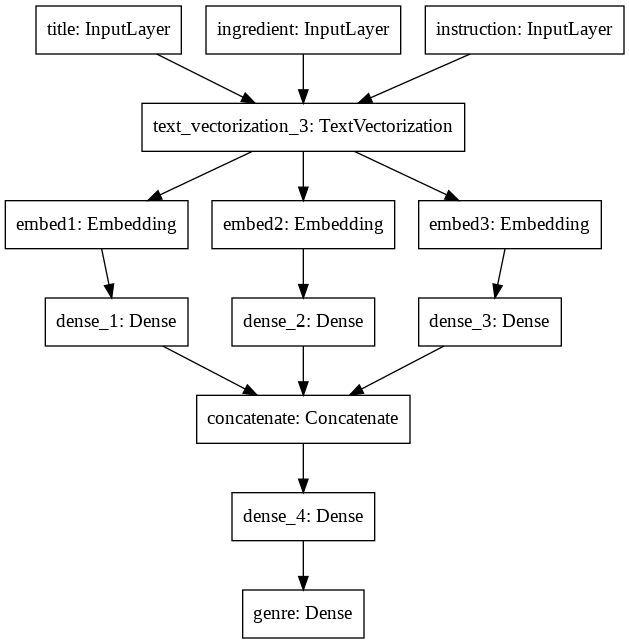

In [ ]:
keras.utils.plot_model(model)

In [ ]:
from tensorflow.keras import losses

In [ ]:
model.compile(optimizer = "adam",
              loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
)

In [ ]:
history = model.fit(train, 
                    validation_data=val,
                    epochs = 1, 
                    verbose = True)

ValueError: ignored